In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import set_seed
import torch
import matplotlib.pyplot as plt
from huggingface_hub import HfApi, login, hf_hub_download
from google.colab import userdata

from supplementary_gpt_trainer import *

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
file_path = "witten_latex_dataset/splits/train.txt"
with open(file_path,'r',encoding='utf-8') as f:
  witten_train_text = f.read()

file_path = "witten_latex_dataset/splits/val.txt"
with open(file_path,'r',encoding='utf-8') as f:
  witten_val_text = f.read()

In [ ]:
# Even though the context length
# for GPT2 is 1024, we will take
# the context length to be 256
# to ensure we can run the
# experiment on Google Colab.

# Choice of context window
context_length = 256
# Choice of batch_size for training
batch_size = 12
# Setting seed for reproducibility
set_seed(42)

# Train (Tokenized) Dataset
train_data = get_tokenized_data(tokenizer = tokenizer,
                                data_file = witten_train_text,
                                batch_size = batch_size,
                                context_length = context_length,
                                shuffle = True,
                                )

# Validation (Tokenized) Dataset
val_data = get_tokenized_data(tokenizer = tokenizer,
                                data_file = witten_val_text,
                                batch_size = batch_size,
                                context_length = context_length,
                                )

Token indices sequence length is longer than the specified maximum sequence length for this model (5526173 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
print(f"{train_data.shape=}")
print(f"{val_data.shape=}")

train_data.shape=torch.Size([1798, 12, 256])
val_data.shape=torch.Size([182, 12, 256])


# Session $1$ - Epochs 0 and 1
## Constant learning rate of $5 \times 10^{-5}$.

In [ ]:
epochs_list = [0,1]
learning_rate = 5e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': None,
          }

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 0, step 0: training loss is 3.8794159325924547 and validation loss is 3.4473988649609324
Epoch 0, step 50: training loss is 3.1739169293707543 and validation loss is 2.95268120935985
Epoch 0, step 100: training loss is 3.039516590453766 and validation loss is 2.8468777576645654
Epoch 0, step 150: training loss is 2.9733081309349982 and validation loss is 2.7857525803885617
Epoch 0, step 200: training loss is 2.9171350866883667 and validation loss is 2.7445594383465064
Epoch 0, step 250: training loss is 2.8753835565441257 and validation loss is 2.7068108952307437
Epoch 0, step 300: training loss is 2.8441452377445096 and validation loss is 2.6780104348947713
Epoch 0, step 350: training loss is 2.8138428153572503 and validation loss is 2.653856117646773
Epoch 0, step 400: training loss is 2.7879023591240686 and validation loss is 2.630006411573389
Epoch 0, step 450: training loss is 2.7639993678082475 and validation loss is 2.614014059960187
Epoch 0, step 500: training loss is 2.7

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'after_session_1/train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'after_session_1/val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

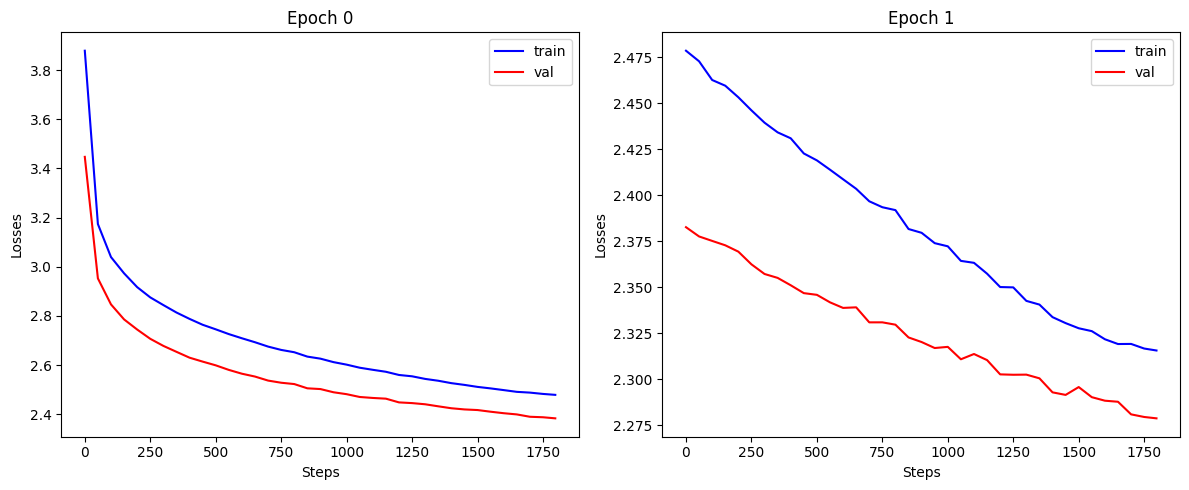

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="after_session_1/trained_model_weights_after_epoch_0.pth",
    path_in_repo="trained_model_weights_after_session_1_epoch_0.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="after_session_1/trained_model_weights_after_epoch_1.pth",
    path_in_repo="trained_model_weights_after_session_1_epoch_1.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_0.pth:   0%|          |  551kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_1.pth:   0%|          |  552kB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/73dc8953a441329a7535adbf447d6e12fa6fb9c4', commit_message='Upload trained_model_weights_after_session_1_epoch_1.pth with huggingface_hub', commit_description='', oid='73dc8953a441329a7535adbf447d6e12fa6fb9c4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $2$ - Epochs 0 and 1
## With linear scheduler: Initial learning rate of $5 \times 10^{-5}$ and final learning rate of $3\times 10^{-5}$.

In [ ]:
epochs_list = [0,1]
learning_rate = 5e-5
final_lr = 3e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 0, step 0: training loss is 3.8794159496223535 and validation loss is 3.4473988518610104
Epoch 0, step 50: training loss is 3.174293578326047 and validation loss is 2.952988523703355
Epoch 0, step 100: training loss is 3.040343157537691 and validation loss is 2.8475087121292786
Epoch 0, step 150: training loss is 2.9744762706232595 and validation loss is 2.7865579691562026
Epoch 0, step 200: training loss is 2.9187162210653117 and validation loss is 2.745931082701945
Epoch 0, step 250: training loss is 2.8771116746650947 and validation loss is 2.708288557909347
Epoch 0, step 300: training loss is 2.8463057554685154 and validation loss is 2.679648605021802
Epoch 0, step 350: training loss is 2.816318133375147 and validation loss is 2.6558362930030612
Epoch 0, step 400: training loss is 2.790703448620471 and validation loss is 2.632417340855022
Epoch 0, step 450: training loss is 2.7676596222343024 and validation loss is 2.6168746460270094
Epoch 0, step 500: training loss is 2.7492

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

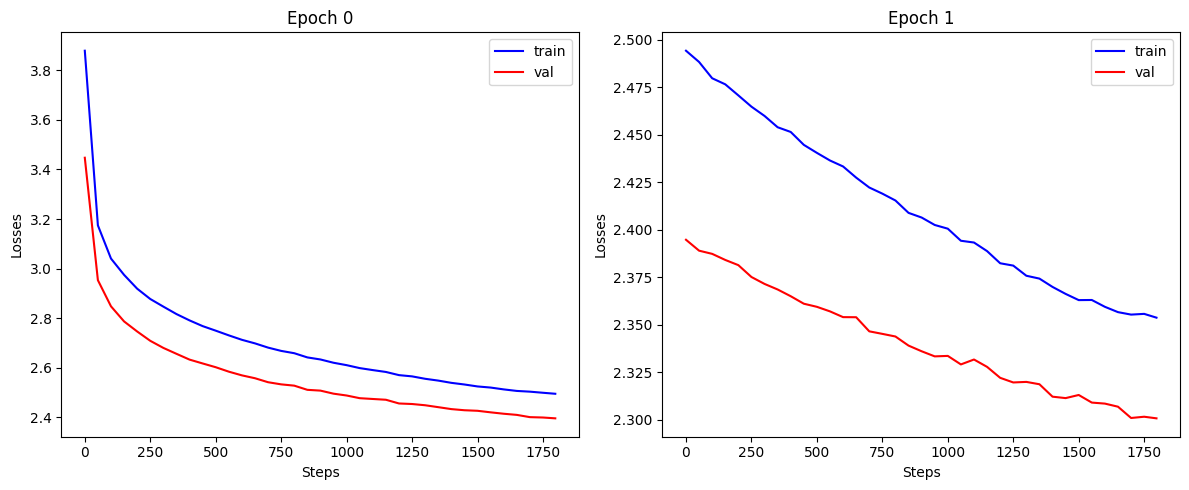

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_0.pth",
    path_in_repo="trained_model_weights_after_session_2_epoch_0.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_1.pth",
    path_in_repo="trained_model_weights_after_session_2_epoch_1.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_0.pth:   0%|          |  552kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_1.pth:   0%|          |  551kB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/8e2bb0467797eab194d9d38dc22e570f84ac900a', commit_message='Upload trained_model_weights_after_session_2_epoch_1.pth with huggingface_hub', commit_description='', oid='8e2bb0467797eab194d9d38dc22e570f84ac900a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $3$ - Epochs 2 and 3
## Constant learning rate of $5 \times 10^{-5}$.
## Assuming the epochs 0 and 1 were trained with the constant learning rate of $5 \times 10^{-5}$ (i.e. session 1).

In [ ]:
epochs_list = [2,3]
learning_rate = 5e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': None,
          }

In [ ]:
# Loading model weights from HF
# We need weights after session 1

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_1_epoch_1.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_1_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 2, step 0: training loss is 2.315068835740561 and validation loss is 2.2759684448713786
Epoch 2, step 50: training loss is 2.3141005019565206 and validation loss is 2.2805589257360817
Epoch 2, step 100: training loss is 2.3097173827035085 and validation loss is 2.2835409487341787
Epoch 2, step 150: training loss is 2.3083365670927276 and validation loss is 2.2829732449500115
Epoch 2, step 200: training loss is 2.3028641519965705 and validation loss is 2.280584762384603
Epoch 2, step 250: training loss is 2.2973682493953915 and validation loss is 2.277589650927009
Epoch 2, step 300: training loss is 2.2959764200252493 and validation loss is 2.2788399035459035
Epoch 2, step 350: training loss is 2.2912471425402297 and validation loss is 2.2796817821460764
Epoch 2, step 400: training loss is 2.288897637482528 and validation loss is 2.2755683598282572
Epoch 2, step 450: training loss is 2.2843662185983344 and validation loss is 2.2755023879664287
Epoch 2, step 500: training loss is 2

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

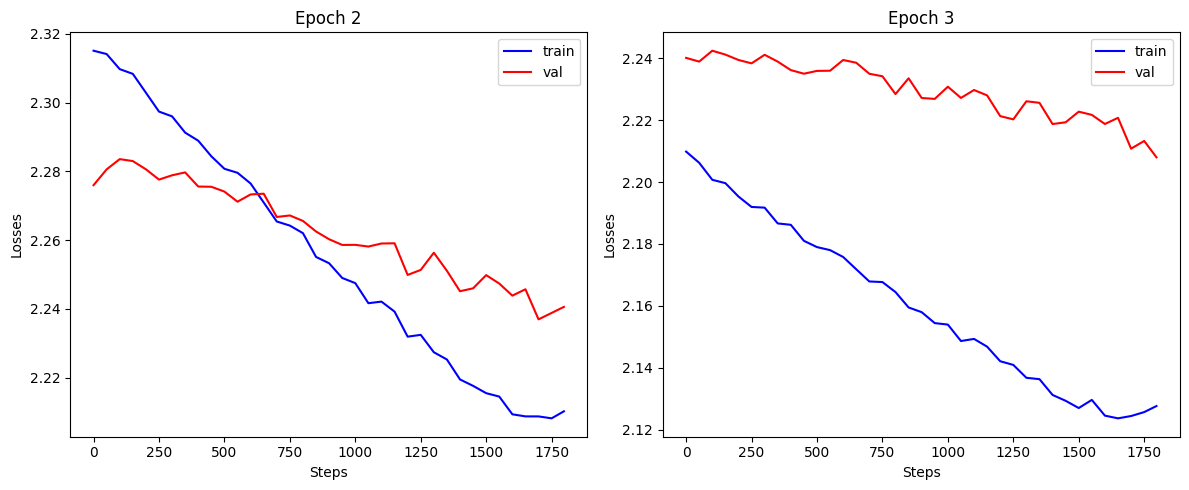

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_2.pth",
    path_in_repo="trained_model_weights_after_session_3_epoch_2.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_3.pth",
    path_in_repo="trained_model_weights_after_session_3_epoch_3.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_2.pth:   0%|          |  551kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_3.pth:   0%|          |  552kB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/67d3beb6cb9de539fe70bc7409f99c0209e7f421', commit_message='Upload trained_model_weights_after_session_3_epoch_3.pth with huggingface_hub', commit_description='', oid='67d3beb6cb9de539fe70bc7409f99c0209e7f421', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $4$ - Epochs 2 and 3
## Constant learning rate of $3 \times 10^{-5}$.
## Assuming the epochs 0 and 1 were trained with the constant learning rate of $5 \times 10^{-5}$ (i.e. session 1).

In [ ]:
epochs_list = [2,3]
learning_rate = 3e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': None,
          }

In [ ]:
# Loading model weights from HF
# We need weights after session 1

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_1_epoch_1.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_1_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 2, step 0: training loss is 2.3138821989625367 and validation loss is 2.2760037114987006
Epoch 2, step 50: training loss is 2.3066411974665884 and validation loss is 2.274627360668811
Epoch 2, step 100: training loss is 2.304404827264639 and validation loss is 2.276281701011972
Epoch 2, step 150: training loss is 2.3030272846693522 and validation loss is 2.275362707756378
Epoch 2, step 200: training loss is 2.297406079349937 and validation loss is 2.2748021696295058
Epoch 2, step 250: training loss is 2.2934943594775357 and validation loss is 2.2722306074676935
Epoch 2, step 300: training loss is 2.2937634017441297 and validation loss is 2.273259494658355
Epoch 2, step 350: training loss is 2.2884726439203535 and validation loss is 2.272445430467417
Epoch 2, step 400: training loss is 2.28747820854187 and validation loss is 2.271678458858322
Epoch 2, step 450: training loss is 2.2845389279690416 and validation loss is 2.270151438293876
Epoch 2, step 500: training loss is 2.281859

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

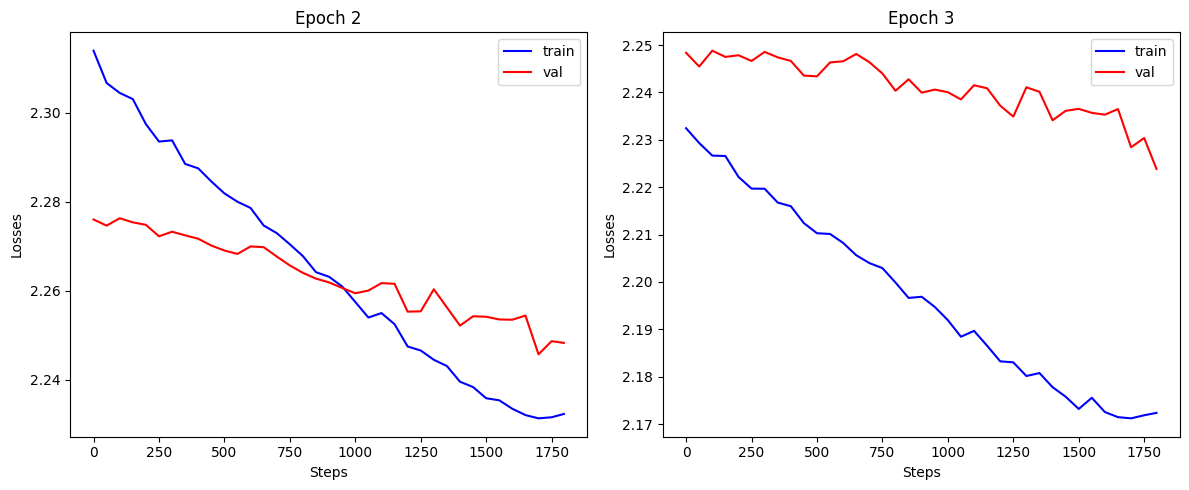

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_2.pth",
    path_in_repo="trained_model_weights_after_session_4_epoch_2.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_3.pth",
    path_in_repo="trained_model_weights_after_session_4_epoch_3.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_2.pth:   0%|          |  552kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_3.pth:   0%|          |  551kB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/3198fae83cb0b0923e14c3e612fbf89d6e8ec276', commit_message='Upload trained_model_weights_after_session_4_epoch_3.pth with huggingface_hub', commit_description='', oid='3198fae83cb0b0923e14c3e612fbf89d6e8ec276', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $5$ - Epochs 2 and 3
## Constant learning rate of $2 \times 10^{-5}$.
## Assuming the epochs 0 and 1 were trained with the constant learning rate of $5 \times 10^{-5}$ (i.e. session 1).

In [ ]:
epochs_list = [2,3]
learning_rate = 2e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': None,
          }

In [ ]:
# Loading model weights from HF
# We need weights after session 1

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_1_epoch_1.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_1_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 2, step 0: training loss is 2.313973675062368 and validation loss is 2.276544753339264
Epoch 2, step 50: training loss is 2.304954149565854 and validation loss is 2.272504677484324
Epoch 2, step 100: training loss is 2.3027794367664463 and validation loss is 2.2739638063933825
Epoch 2, step 150: training loss is 2.3010805452262963 and validation loss is 2.27102614398841
Epoch 2, step 200: training loss is 2.2962586152684556 and validation loss is 2.2719706942091933
Epoch 2, step 250: training loss is 2.293504473272261 and validation loss is 2.2705632268072486
Epoch 2, step 300: training loss is 2.2927856137464335 and validation loss is 2.2701868473828495
Epoch 2, step 350: training loss is 2.2898931948693244 and validation loss is 2.2706823689596995
Epoch 2, step 400: training loss is 2.287595503932827 and validation loss is 2.2694849437409705
Epoch 2, step 450: training loss is 2.2857421918229743 and validation loss is 2.26865715443433
Epoch 2, step 500: training loss is 2.28281

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

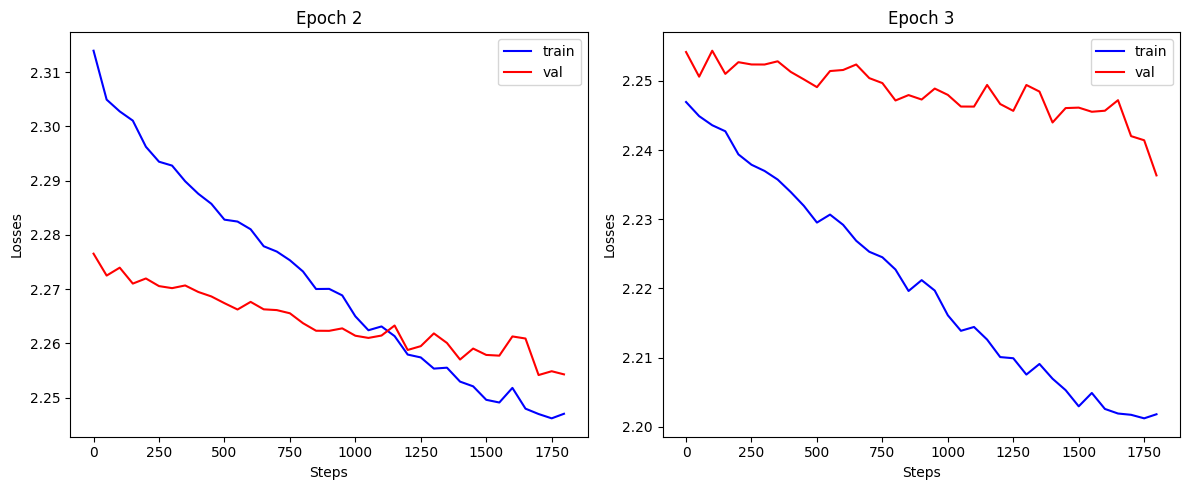

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_2.pth",
    path_in_repo="trained_model_weights_after_session_5_epoch_2.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_3.pth",
    path_in_repo="trained_model_weights_after_session_5_epoch_3.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_2.pth:   0%|          |  552kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_3.pth:   0%|          |  551kB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/3598b2e344847f98ba212b862cacd437249bf5b3', commit_message='Upload trained_model_weights_after_session_5_epoch_3.pth with huggingface_hub', commit_description='', oid='3598b2e344847f98ba212b862cacd437249bf5b3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $6$ - Epochs 2 and 3
## Linearly decaying learning rate with initial value of $3 \times 10^{-5}$ and final value of $1 \times 10^{-5}$.
## Again, we assume that the epochs 0 and 1 were trained with the constant learning rate of $5 \times 10^{-5}$ (i.e. session 1).

In [ ]:
epochs_list = [2,3]
learning_rate = 3e-5
final_lr = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
# Loading model weights from HF
# We need weights after session 1

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_1_epoch_1.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_1_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 2, step 0: training loss is 2.3138821786576576 and validation loss is 2.276003700363767
Epoch 2, step 50: training loss is 2.306598288017315 and validation loss is 2.2745840703393077
Epoch 2, step 100: training loss is 2.3043488395083083 and validation loss is 2.2761901770974253
Epoch 2, step 150: training loss is 2.3028953271907766 and validation loss is 2.2750759553778304
Epoch 2, step 200: training loss is 2.2972279020718167 and validation loss is 2.2745192912253707
Epoch 2, step 250: training loss is 2.2933768898576172 and validation loss is 2.272016708012466
Epoch 2, step 300: training loss is 2.2933947208163503 and validation loss is 2.2727363037539052
Epoch 2, step 350: training loss is 2.2883840871381236 and validation loss is 2.2718862128126753
Epoch 2, step 400: training loss is 2.287067715283279 and validation loss is 2.2711890650974524
Epoch 2, step 450: training loss is 2.284301812832172 and validation loss is 2.2696936274622823
Epoch 2, step 500: training loss is 2.

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

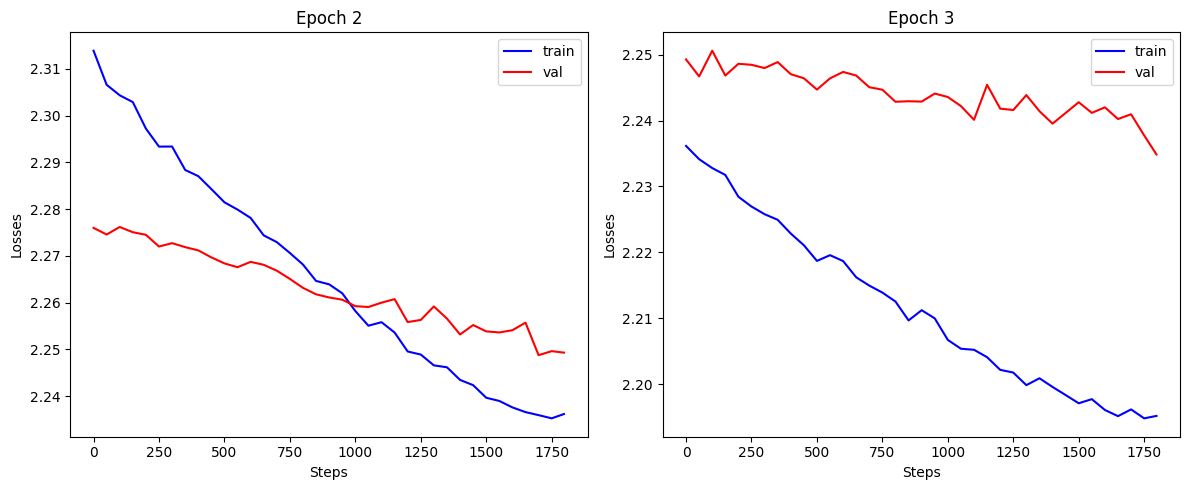

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_2.pth",
    path_in_repo="trained_model_weights_after_session_6_epoch_2.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_3.pth",
    path_in_repo="trained_model_weights_after_session_6_epoch_3.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_2.pth:   0%|          |  552kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_3.pth:   0%|          |  552kB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/5883df4e60a4ef4531f01ca7669bba580a3faab3', commit_message='Upload trained_model_weights_after_session_6_epoch_3.pth with huggingface_hub', commit_description='', oid='5883df4e60a4ef4531f01ca7669bba580a3faab3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $7$ - Epochs 2 and 3
## Linearly decaying learning rate with initial value of $2 \times 10^{-5}$ and final value of zero.
## Again, we assume that the epochs 0 and 1 were trained with the constant learning rate of $5 \times 10^{-5}$ (i.e. session 1).

In [ ]:
epochs_list = [2,3]
learning_rate = 2e-5
final_lr = 0.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
# Loading model weights from HF
# We need weights after session 1

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_1_epoch_1.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_1_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 2, step 0: training loss is 2.313973675062368 and validation loss is 2.276544745479311
Epoch 2, step 50: training loss is 2.304941489146306 and validation loss is 2.272494484762569
Epoch 2, step 100: training loss is 2.302706559935769 and validation loss is 2.27387697159589
Epoch 2, step 150: training loss is 2.3008844465999814 and validation loss is 2.270745651080058
Epoch 2, step 200: training loss is 2.296121147962717 and validation loss is 2.2717566064425876
Epoch 2, step 250: training loss is 2.2934306185324114 and validation loss is 2.2703209617635705
Epoch 2, step 300: training loss is 2.2925497876418817 and validation loss is 2.2697029474017385
Epoch 2, step 350: training loss is 2.2900210108075822 and validation loss is 2.2704604746221184
Epoch 2, step 400: training loss is 2.2874448692405616 and validation loss is 2.268953729461838
Epoch 2, step 450: training loss is 2.2857521097738664 and validation loss is 2.2682868373263014
Epoch 2, step 500: training loss is 2.28288

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

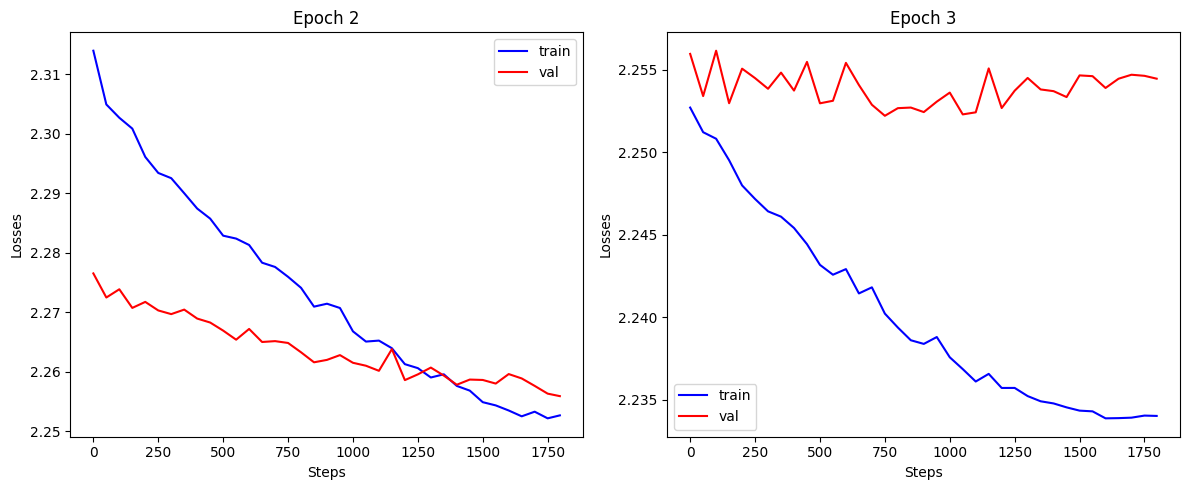

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_2.pth",
    path_in_repo="trained_model_weights_after_session_7_epoch_2.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_3.pth",
    path_in_repo="trained_model_weights_after_session_7_epoch_3.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_2.pth:   0%|          | 1.10MB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_3.pth:   0%|          |  550kB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/0c062f768f39834115e36425119ab9247489ae19', commit_message='Upload trained_model_weights_after_session_7_epoch_3.pth with huggingface_hub', commit_description='', oid='0c062f768f39834115e36425119ab9247489ae19', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $8$ - Epochs 2 and 3
## Linearly decaying learning rate with initial value of $3 \times 10^{-5}$ and final value of $1 \times 10^{-5}$.
## Now, we assume that the epochs 0 and 1 were trained with the linearly reduced learning rate from $5 \times 10^{-5}$ to $3 \times 10^{-5}$ (i.e. session 2).

In [ ]:
epochs_list = [2,3]
learning_rate = 3e-5
final_lr = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
# Loading model weights from HF
# This time, we need weights after session 2

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_2_epoch_1.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_2_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 2, step 0: training loss is 2.3529144879225847 and validation loss is 2.2986068499612284
Epoch 2, step 50: training loss is 2.3504197761252685 and validation loss is 2.300565172682752
Epoch 2, step 100: training loss is 2.3486650704027534 and validation loss is 2.3033056534253635
Epoch 2, step 150: training loss is 2.347934754340203 and validation loss is 2.30258206646521
Epoch 2, step 200: training loss is 2.342863151005336 and validation loss is 2.302110188609951
Epoch 2, step 250: training loss is 2.3390355837214125 and validation loss is 2.29901758818836
Epoch 2, step 300: training loss is 2.3394971260657678 and validation loss is 2.3006631407763933
Epoch 2, step 350: training loss is 2.3339637308330325 and validation loss is 2.298900304259835
Epoch 2, step 400: training loss is 2.332921727673038 and validation loss is 2.2981271069128435
Epoch 2, step 450: training loss is 2.3299137910643775 and validation loss is 2.296293996520095
Epoch 2, step 500: training loss is 2.327172

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

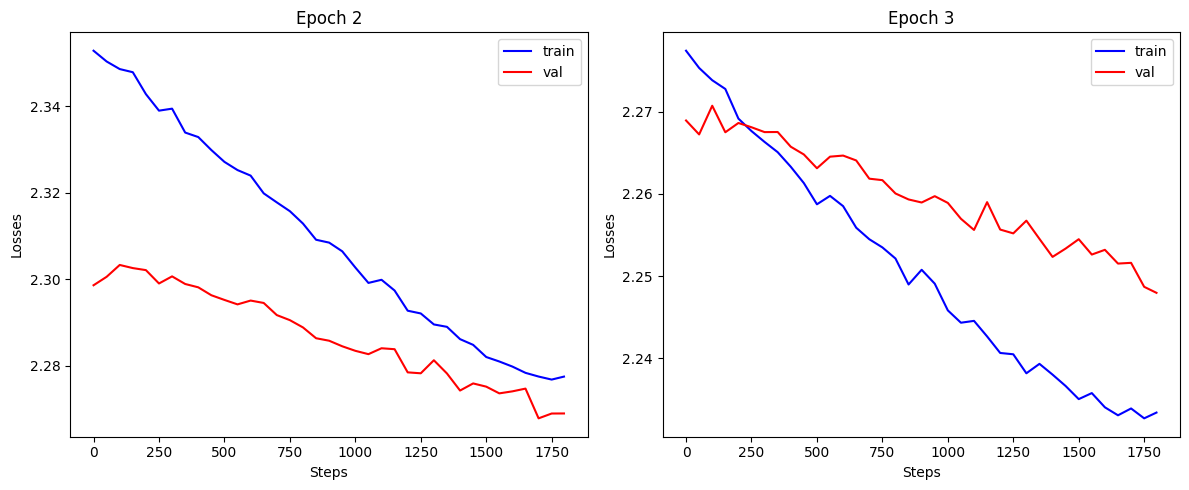

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_2.pth",
    path_in_repo="trained_model_weights_after_session_8_epoch_2.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_3.pth",
    path_in_repo="trained_model_weights_after_session_8_epoch_3.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_2.pth:   0%|          |  551kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_3.pth:   1%|          | 3.86MB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/996efa914249c653bdfe3e2374dbf219ed43ea23', commit_message='Upload trained_model_weights_after_session_8_epoch_3.pth with huggingface_hub', commit_description='', oid='996efa914249c653bdfe3e2374dbf219ed43ea23', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $9$ - Epochs 2 and 3
## Linearly decaying learning rate with initial value of $3 \times 10^{-5}$ and final value of zero.
## We assume that the epochs 0 and 1 were trained with the linearly reduced learning rate from $5 \times 10^{-5}$ to $3 \times 10^{-5}$ (i.e. session 2).

In [ ]:
epochs_list = [2,3]
learning_rate = 3e-5
final_lr = 0.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
# Loading model weights from HF
# This time, we need weights after session 2

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_2_epoch_1.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_2_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 2, step 0: training loss is 2.3529144872675887 and validation loss is 2.2986068417737773
Epoch 2, step 50: training loss is 2.350390057642381 and validation loss is 2.300537809893325
Epoch 2, step 100: training loss is 2.348632583906362 and validation loss is 2.3032488433214335
Epoch 2, step 150: training loss is 2.347850407872881 and validation loss is 2.3024444239480153
Epoch 2, step 200: training loss is 2.342732569018563 and validation loss is 2.301959982940129
Epoch 2, step 250: training loss is 2.3389425022261485 and validation loss is 2.2988936524469774
Epoch 2, step 300: training loss is 2.3392852282786105 and validation loss is 2.3003881783275815
Epoch 2, step 350: training loss is 2.3338919380208947 and validation loss is 2.2985954536841464
Epoch 2, step 400: training loss is 2.3327012933217564 and validation loss is 2.297848880290985
Epoch 2, step 450: training loss is 2.329806943516155 and validation loss is 2.2960771207626047
Epoch 2, step 500: training loss is 2.327

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

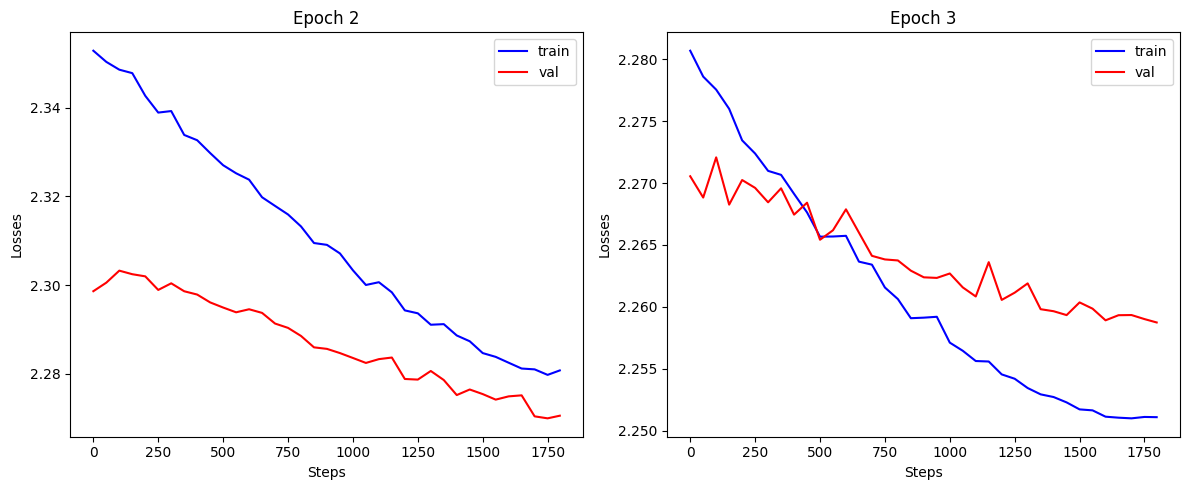

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_2.pth",
    path_in_repo="trained_model_weights_after_session_9_epoch_2.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_3.pth",
    path_in_repo="trained_model_weights_after_session_9_epoch_3.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_2.pth:   0%|          |  551kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_3.pth:   1%|          | 3.86MB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/f3c0e52069b2f2be07160d4d295cb1a9635ac73d', commit_message='Upload trained_model_weights_after_session_9_epoch_3.pth with huggingface_hub', commit_description='', oid='f3c0e52069b2f2be07160d4d295cb1a9635ac73d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $10$ - Epochs 4 and 5
## Constant learning rate of $5 \times 10^{-5}$.
## We assume that the epochs $0$-$3$ were trained with the constant rate of  $5 \times 10^{-5}$ (i.e. session 3).

In [ ]:
epochs_list = [4,5]
learning_rate = 5e-5
final_lr = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
# Loading model weights from HF
# This time, we need weights after session 2

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_3_epoch_3.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_3_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 4, step 0: training loss is 2.124545779857007 and validation loss is 2.2116467340306922
Epoch 4, step 50: training loss is 2.123503905076247 and validation loss is 2.217295914888382
Epoch 4, step 100: training loss is 2.1215170530172496 and validation loss is 2.219415076813855
Epoch 4, step 150: training loss is 2.1233849754700294 and validation loss is 2.2240775178421983
Epoch 4, step 200: training loss is 2.117747260974004 and validation loss is 2.223354317329742
Epoch 4, step 250: training loss is 2.1135490720088663 and validation loss is 2.2208804999079024
Epoch 4, step 300: training loss is 2.1157481984777764 and validation loss is 2.2260613326842966
Epoch 4, step 350: training loss is 2.109574402426625 and validation loss is 2.2294372752472595
Epoch 4, step 400: training loss is 2.109710997277564 and validation loss is 2.2264660862120955
Epoch 4, step 450: training loss is 2.107221869976966 and validation loss is 2.2285616519031946
Epoch 4, step 500: training loss is 2.1035

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

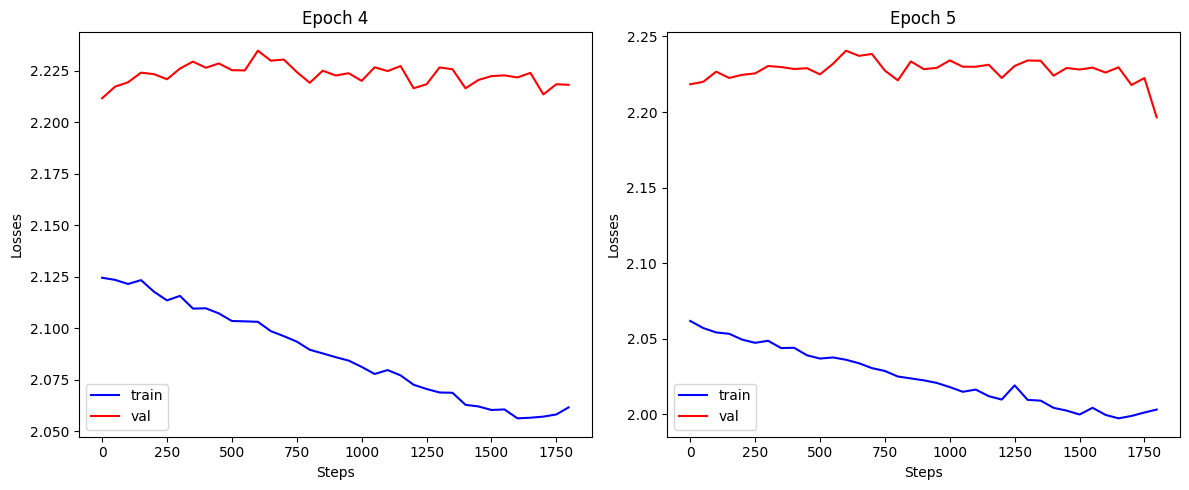

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_4.pth",
    path_in_repo="trained_model_weights_after_session_10_epoch_4.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_5.pth",
    path_in_repo="trained_model_weights_after_session_10_epoch_5.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_4.pth:   0%|          |  552kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_5.pth:   1%|          | 3.86MB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/32636f60af8997a31666c1ea33d8b4dc98288830', commit_message='Upload trained_model_weights_after_session_10_epoch_5.pth with huggingface_hub', commit_description='', oid='32636f60af8997a31666c1ea33d8b4dc98288830', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $11$ - Epochs 4 and 5
## Constant learning rate of $3 \times 10^{-5}$.
## We assume that the epochs $0$-$3$ were trained with the constant rate of  $5 \times 10^{-5}$ (i.e. session 3).

In [ ]:
epochs_list = [4,5]
learning_rate = 3e-5
final_lr = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
# Loading model weights from HF
# This time, we need weights after session 2

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_3_epoch_3.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_3_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 4, step 0: training loss is 2.1248066562872667 and validation loss is 2.209343814915353
Epoch 4, step 50: training loss is 2.117763951584533 and validation loss is 2.2122756458900787
Epoch 4, step 100: training loss is 2.115909695625305 and validation loss is 2.212568923012241
Epoch 4, step 150: training loss is 2.116326383836977 and validation loss is 2.2129098750077763
Epoch 4, step 200: training loss is 2.110840204652849 and validation loss is 2.2152911585110884
Epoch 4, step 250: training loss is 2.107623455943642 and validation loss is 2.215755742657316
Epoch 4, step 300: training loss is 2.1090706920885776 and validation loss is 2.216168980677049
Epoch 4, step 350: training loss is 2.1054664588236545 and validation loss is 2.221349304848975
Epoch 4, step 400: training loss is 2.1043773051146624 and validation loss is 2.221399871857612
Epoch 4, step 450: training loss is 2.102043084390871 and validation loss is 2.2209504410460754
Epoch 4, step 500: training loss is 2.0994648

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_4.pth",
    path_in_repo="trained_model_weights_after_session_11_epoch_4.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_5.pth",
    path_in_repo="trained_model_weights_after_session_11_epoch_5.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_4.pth:   0%|          |  551kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_5.pth:   1%|          | 3.86MB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/6c67ea1de30b6c9291966c46e6545471579efe40', commit_message='Upload trained_model_weights_after_session_11_epoch_5.pth with huggingface_hub', commit_description='', oid='6c67ea1de30b6c9291966c46e6545471579efe40', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $12$ - Epochs 4 and 5
## Constant learning rate of $3 \times 10^{-5}$.
## We assume that the epochs $0$ and $1$ were trained with the constant rate of  $5 \times 10^{-5}$ whereas the epochs $2$ and $3$ were trained with the constant rate of  $3 \times 10^{-5}$. (That is, this is a continuation of the session 4).

In [ ]:
epochs_list = [4,5]
learning_rate = 3e-5
final_lr = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
# Loading model weights from HF
# This time, we need weights after session 2

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_4_epoch_3.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_4_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 4, step 0: training loss is 2.171485201343075 and validation loss is 2.225442708521099
Epoch 4, step 50: training loss is 2.169803853873368 and validation loss is 2.2266902648485623
Epoch 4, step 100: training loss is 2.1693365462533722 and validation loss is 2.2286587612969533
Epoch 4, step 150: training loss is 2.170365843799088 and validation loss is 2.2294244527161777
Epoch 4, step 200: training loss is 2.1657736406221493 and validation loss is 2.23056176337567
Epoch 4, step 250: training loss is 2.162852793604463 and validation loss is 2.2295343571311825
Epoch 4, step 300: training loss is 2.1641928795929792 and validation loss is 2.2310261595380174
Epoch 4, step 350: training loss is 2.160863322216076 and validation loss is 2.2344080838528306
Epoch 4, step 400: training loss is 2.16025200846431 and validation loss is 2.2344830065638153
Epoch 4, step 450: training loss is 2.1583800119358103 and validation loss is 2.2338239770014208
Epoch 4, step 500: training loss is 2.15595

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

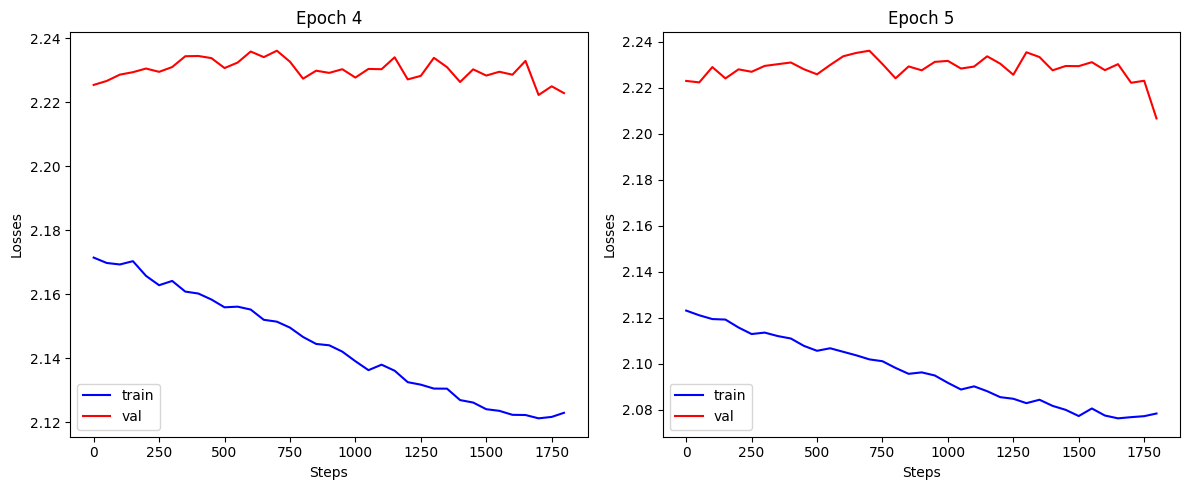

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_4.pth",
    path_in_repo="trained_model_weights_after_session_12_epoch_4.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_5.pth",
    path_in_repo="trained_model_weights_after_session_12_epoch_5.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_4.pth:   0%|          |  551kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_5.pth:   1%|          | 3.86MB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/11158ce65b883d4b535c7af2528b4acc1cd0b250', commit_message='Upload trained_model_weights_after_session_12_epoch_5.pth with huggingface_hub', commit_description='', oid='11158ce65b883d4b535c7af2528b4acc1cd0b250', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $13$ - Epochs 4 and 5
## Constant learning rate of $1 \times 10^{-5}$.
## We assume that the epochs $0$ and $1$ were trained with the constant rate of  $5 \times 10^{-5}$ whereas the epochs $2$ and $3$ were trained with the constant rate of  $3 \times 10^{-5}$. (That is, this is a continuation of the session 4).

In [ ]:
epochs_list = [4,5]
learning_rate = 1e-5
final_lr = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
# Loading model weights from HF
# This time, we need weights after session 2

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_4_epoch_3.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_4_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 4, step 0: training loss is 2.171746390206473 and validation loss is 2.2241398076434713
Epoch 4, step 50: training loss is 2.1665400718594645 and validation loss is 2.224452576139471
Epoch 4, step 100: training loss is 2.165197484440856 and validation loss is 2.2249436480003397
Epoch 4, step 150: training loss is 2.1635524741895904 and validation loss is 2.2211326907624254
Epoch 4, step 200: training loss is 2.161846072464199 and validation loss is 2.2249960552205095
Epoch 4, step 250: training loss is 2.1606321151439962 and validation loss is 2.2244175859205018
Epoch 4, step 300: training loss is 2.1599920195537607 and validation loss is 2.2240888345372545
Epoch 4, step 350: training loss is 2.1590402119762295 and validation loss is 2.2262080832497104
Epoch 4, step 400: training loss is 2.1575288641583787 and validation loss is 2.2258527219950497
Epoch 4, step 450: training loss is 2.156862068962265 and validation loss is 2.2274391097681865
Epoch 4, step 500: training loss is 2.

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

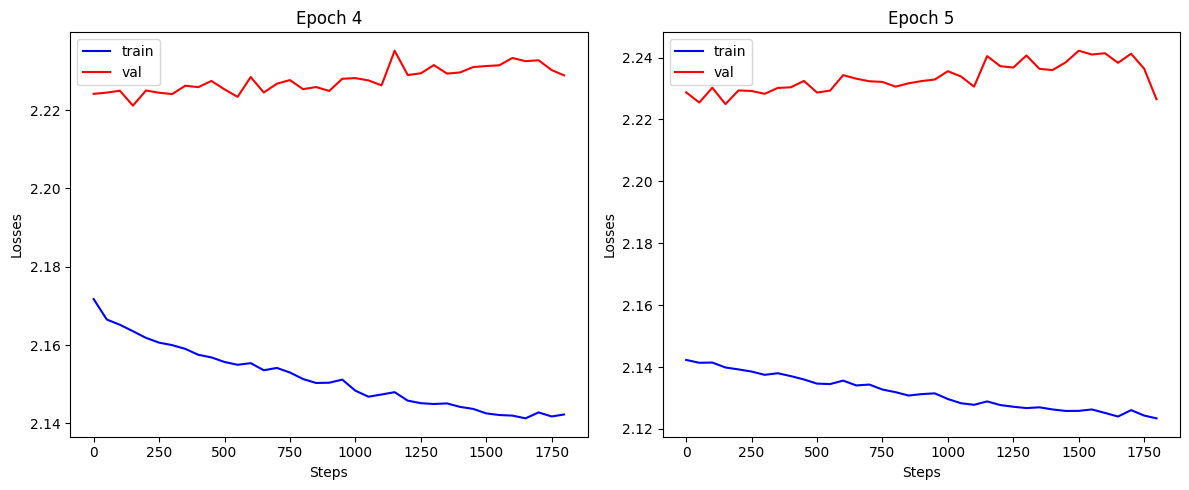

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_4.pth",
    path_in_repo="trained_model_weights_after_session_13_epoch_4.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_5.pth",
    path_in_repo="trained_model_weights_after_session_13_epoch_5.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_4.pth:   0%|          |  550kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_5.pth:   1%|          | 3.86MB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/b5dc50be3476ccd7dd955df63cec2d052c7b2a75', commit_message='Upload trained_model_weights_after_session_13_epoch_5.pth with huggingface_hub', commit_description='', oid='b5dc50be3476ccd7dd955df63cec2d052c7b2a75', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $14$ - Epochs 4 and 5
## Constant learning rate of $1 \times 10^{-5}$.
## We assume that the epochs $0$ and $1$ were trained with the constant rate of  $5 \times 10^{-5}$ whereas the epochs $2$ and $3$ were trained with the linearly decreasing rate from  $3 \times 10^{-5}$ to $1 \times 10^{-5}$. (This is a continuation of the session 6).

In [ ]:
epochs_list = [4,5]
learning_rate = 1e-5
final_lr = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
# Loading model weights from HF
# This time, we need weights after session 2

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_6_epoch_3.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_6_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 4, step 0: training loss is 2.1948692012619184 and validation loss is 2.2352748539421583
Epoch 4, step 50: training loss is 2.194296747773558 and validation loss is 2.235610936041717
Epoch 4, step 100: training loss is 2.1943690534476397 and validation loss is 2.2370633469833123
Epoch 4, step 150: training loss is 2.193553994645129 and validation loss is 2.2335467630035275
Epoch 4, step 200: training loss is 2.192356818979913 and validation loss is 2.2377533388661814
Epoch 4, step 250: training loss is 2.1916725301480557 and validation loss is 2.237191305710719
Epoch 4, step 300: training loss is 2.1915372603542203 and validation loss is 2.237171999700777
Epoch 4, step 350: training loss is 2.19113773893524 and validation loss is 2.239652630392012
Epoch 4, step 400: training loss is 2.1897987585801344 and validation loss is 2.2390048674174716
Epoch 4, step 450: training loss is 2.1895023682615258 and validation loss is 2.2403774107550527
Epoch 4, step 500: training loss is 2.1882

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

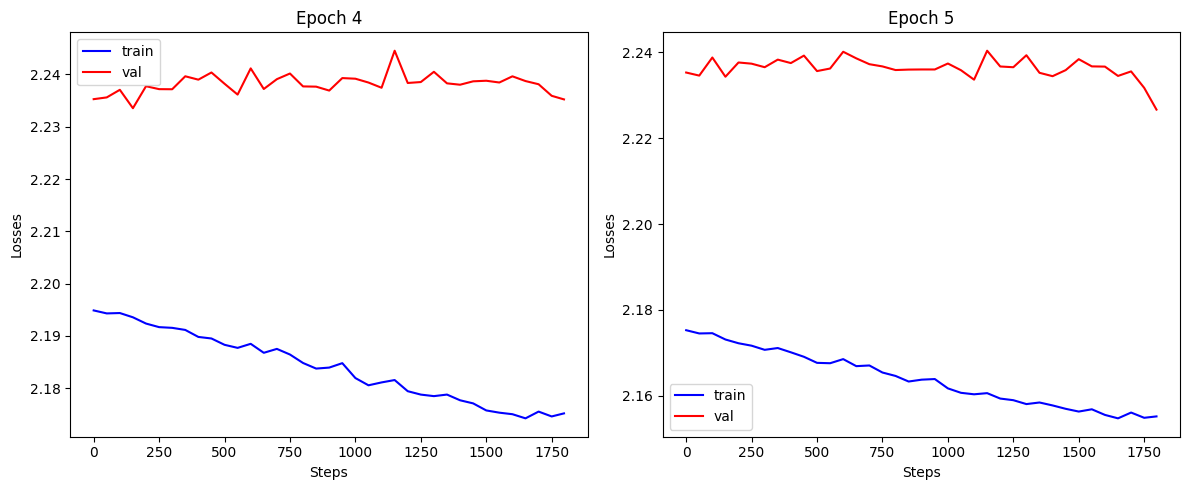

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_4.pth",
    path_in_repo="trained_model_weights_after_session_14_epoch_4.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_5.pth",
    path_in_repo="trained_model_weights_after_session_14_epoch_5.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_4.pth:   0%|          |  552kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_5.pth:   1%|          | 3.86MB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/cd676c73a98b8930180e9efa574d8edadc0f6b92', commit_message='Upload trained_model_weights_after_session_14_epoch_5.pth with huggingface_hub', commit_description='', oid='cd676c73a98b8930180e9efa574d8edadc0f6b92', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)

# Session $15$ - Epochs 4 and 5
## Constant learning rate of $1 \times 10^{-5}$.
## We assume that the epochs $0$-$3$ were trained with the linearly reduced learning rate from $5 \times 10^{-5}$ to $1 \times 10^{-5}$  (i.e. session 8).

In [ ]:
epochs_list = [4,5]
learning_rate = 1e-5
final_lr = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {'optimizer': AdamW,
          'learning_rate': learning_rate,
          'epochs_list': epochs_list,
          'final_lr': final_lr,
          }

In [ ]:
# Loading model weights from HF
# This time, we need weights after session 2

hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)

# Downloading the model weights file
repo_id = "mudassirmoosa/witten_gpt_private"
file_name = "trained_model_weights_after_session_8_epoch_3.pth"
model_file = hf_hub_download(
    repo_id=repo_id,
    filename=file_name,
    token=hf_token
)

# Load the weights
# Note that the model's device is
# cpu until trainer is initialized.
state_dict = torch.load(model_file, map_location='cpu')
model.load_state_dict(state_dict)

trained_model_weights_after_session_8_ep(…):   0%|          | 0.00/498M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
set_seed(114)

trainer = gpt_trainer(model, train_data, val_data, device, config)
trainer.run()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 4, step 0: training loss is 2.2331222793558143 and validation loss is 2.2484566225455356
Epoch 4, step 50: training loss is 2.2325150704645846 and validation loss is 2.2515488964515726
Epoch 4, step 100: training loss is 2.232699990927518 and validation loss is 2.2536873804343927
Epoch 4, step 150: training loss is 2.231782567370069 and validation loss is 2.250422407310088
Epoch 4, step 200: training loss is 2.230382597053444 and validation loss is 2.2546242419834974
Epoch 4, step 250: training loss is 2.2296373962046028 and validation loss is 2.2540978422531714
Epoch 4, step 300: training loss is 2.2295399393354143 and validation loss is 2.253964656984413
Epoch 4, step 350: training loss is 2.2292079349140543 and validation loss is 2.2566603261690874
Epoch 4, step 400: training loss is 2.227712807419536 and validation loss is 2.255665407730983
Epoch 4, step 450: training loss is 2.2274684539208045 and validation loss is 2.256809129492267
Epoch 4, step 500: training loss is 2.225

In [ ]:
# Saving train_loss (Appending the file)
file_path = 'train_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.train_loss_history:
        f.write(f"{loss}\n")

# Saving val_loss (Appending the file)
file_path = 'val_loss_history.txt'
with open(file_path, 'a') as f:
    for loss in trainer.val_loss_history:
        f.write(f"{loss}\n")

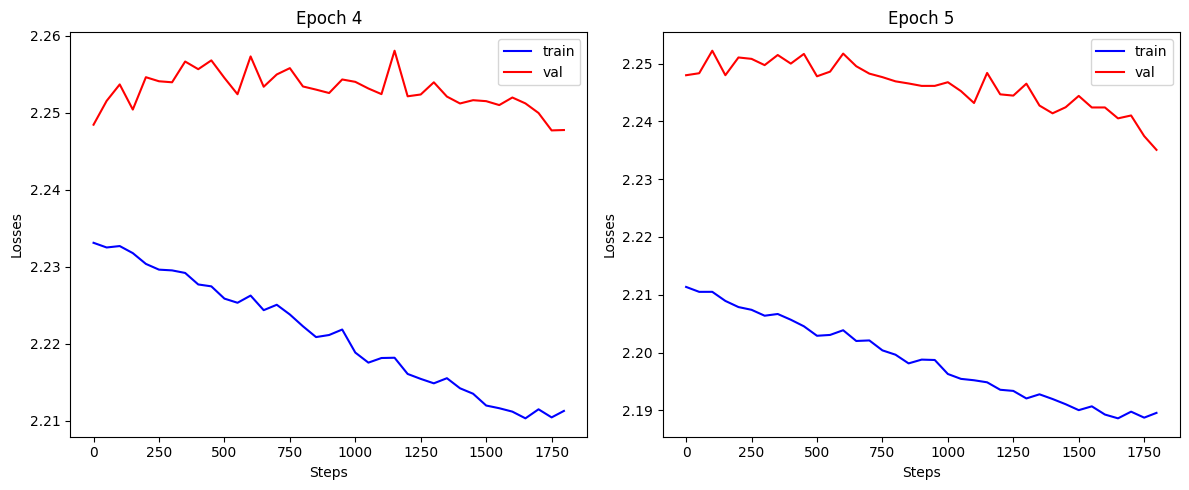

In [ ]:
# Plotting the train and the validation losses

# List of steps
steps = [50*k for k in range(int(trainer.train_data.size(0)/50) + 1)]
if (trainer.train_data.size(0) % 50):
  steps.append(trainer.train_data.size(0) - 1)

fig = plt.figure(figsize=(12, 5))

# First subplot
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(steps, trainer.train_loss_history[:len(steps)], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[:len(steps)], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[0]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

# Second subplot
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(steps, trainer.train_loss_history[len(steps):], color='b', label='train')
ax1.plot(steps, trainer.val_loss_history[len(steps):], color='r', label='val')
ax1.set_title(f'Epoch {epochs_list[1]}')
ax1.legend()
ax1.set_xlabel('Steps')
ax1.set_ylabel('Losses')

plt.tight_layout()
plt.show()

In [ ]:
# Loading weights on Hugging face Hub
hf_token = userdata.get('witten_gpt_TOKEN')
login(token=hf_token)
api = HfApi()

repo_id = "mudassirmoosa/witten_gpt_private"

# Uploading model weights
api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_4.pth",
    path_in_repo="trained_model_weights_after_session_15_epoch_4.pth",
    repo_id=repo_id,
    token=hf_token
)

api.upload_file(
    path_or_fileobj="trained_model_weights_after_epoch_5.pth",
    path_in_repo="trained_model_weights_after_session_15_epoch_5.pth",
    repo_id=repo_id,
    token=hf_token
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_4.pth:   0%|          |  551kB /  498MB            

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...ned_model_weights_after_epoch_5.pth:   1%|          | 3.86MB /  498MB            

CommitInfo(commit_url='https://huggingface.co/mudassirmoosa/witten_gpt_private/commit/e3b9e5f114471e66addfdd86009ded3ad164ff47', commit_message='Upload trained_model_weights_after_session_15_epoch_5.pth with huggingface_hub', commit_description='', oid='e3b9e5f114471e66addfdd86009ded3ad164ff47', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mudassirmoosa/witten_gpt_private', endpoint='https://huggingface.co', repo_type='model', repo_id='mudassirmoosa/witten_gpt_private'), pr_revision=None, pr_num=None)